Andrea Hanel 2024

# Fig. S 5C

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')

sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

!echo "Conda Environment: $CONDA_DEFAULT_ENV"
from datetime import datetime
print(f"Date: {datetime.now():%Y-%m-%d}")

Conda Environment: tired_like_a_kitten
Date: 2024-12-07


In [2]:
adata_jardine = sc.read_h5ad('/research/groups/sysgen/PROJECTS/sysgen_team/andrea_work/VAE-Andrea/output/jardine_processed_withrawcounts.h5ad')
adata_jardine.X = adata_jardine.layers['raw_counts']

#----- query dataset
adata_aggr = sc.read_h5ad("/research/groups/sysgen/PROJECTS/sysgen_team/andrea_work/2023_Fischer_iPSC/revision_final/data/adata2_PCAharmony_leiden_LS_final.h5ad")
adata_aggr.X = adata_aggr.layers["raw_counts"]

In [3]:
adata_jardine.obs['sample'] = adata_jardine.obs['Tissue'].astype(str)

In [4]:
adata_jardine

AnnData object with n_obs × n_vars = 27219 × 24153
    obs: 'Tissue', 'cell.labels', 'lanes', 'sample'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Cell.labels.P4.sorted_colors', 'Cell.labels.P4_colors', 'Sample_colors', 'Stage_colors', 'Tissue_colors', 'assignment_colors', 'cell.labels_colors', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_fdg', 'X_umap'
    varm: 'PCs'
    layers: 'normalized_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [5]:
adata_aggr

AnnData object with n_obs × n_vars = 32358 × 33233
    obs: 'sample', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline', 'leiden_res0_25', 'S_score', 'G2M_score', 'phase', 'phase_combined', 'S/G2M_score_combined', 'Level 1', 'Level 2', 'Max-Rho', 'Combined Correlation DiffScore', 'cell_type_jardine', 'prediction.score.max_jardine'
    var: 'gene_id', 'n_cells', 'highly_variable'
    uns: 'leiden_res0_25_colors'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_orig_pca', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [6]:
#---- add batch
adata_jardine.obs["study"] = "jardine"
adata_aggr.obs["study"] = "iPSC"
adata_aggr.obs["Tissue"] = "iPSC"

In [7]:
adata = adata_jardine.concatenate(adata_aggr)
adata.var["feature_name"] = adata.var_names

In [8]:
adata

AnnData object with n_obs × n_vars = 59577 × 23789
    obs: 'Tissue', 'cell.labels', 'lanes', 'sample', 'study', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline', 'leiden_res0_25', 'S_score', 'G2M_score', 'phase', 'phase_combined', 'S/G2M_score_combined', 'Level 1', 'Level 2', 'Max-Rho', 'Combined Correlation DiffScore', 'cell_type_jardine', 'prediction.score.max_jardine', 'batch'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'highly_variable-1', 'gene_id-1', 'n_cells-1', 'feature_name'
    obsm: 'X_umap'
    layers: 'raw_counts'

In [13]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
#adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=4000,
    layer="counts",
    batch_key="study",
    subset=True,
)

In [16]:
sc.tl.pca(adata, n_comps=50)

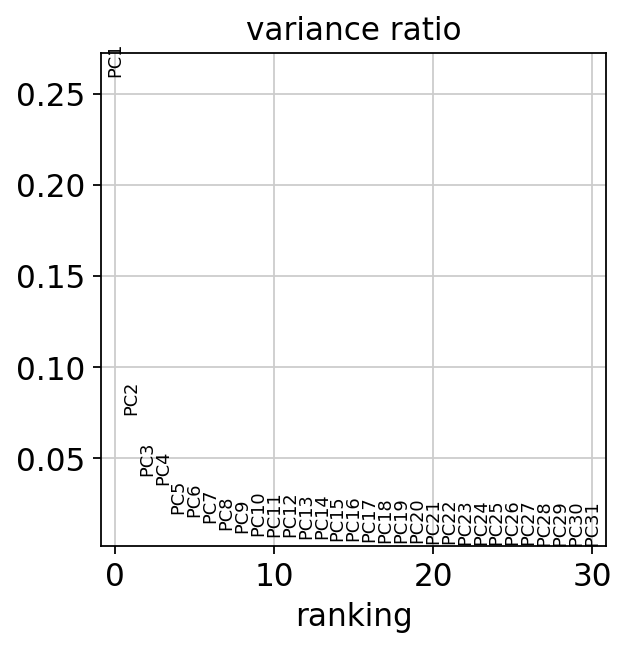

In [17]:
sc.pl.pca_variance_ratio(adata, log=False)

In [18]:
sc.pp.neighbors(adata, 
                n_neighbors=30, n_pcs=50, use_rep=None, knn=True, random_state=0, method='umap', metric='euclidean', 
                 key_added=None, copy=False)

In [21]:
pca = adata.obsm['X_pca']
batch = adata.obs['study']

In [22]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [23]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

#batch <- as.factor(batch)

hem = HarmonyMatrix(pca, batch, theta=5, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

Loading required package: Rcpp
Transposing data matrix
Initializing state using k-means centroids initialization
Harmony 1/10
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 2/10
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 3/10
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
0%   10   20   30   40   50   60   70   80   90   100

In [24]:
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

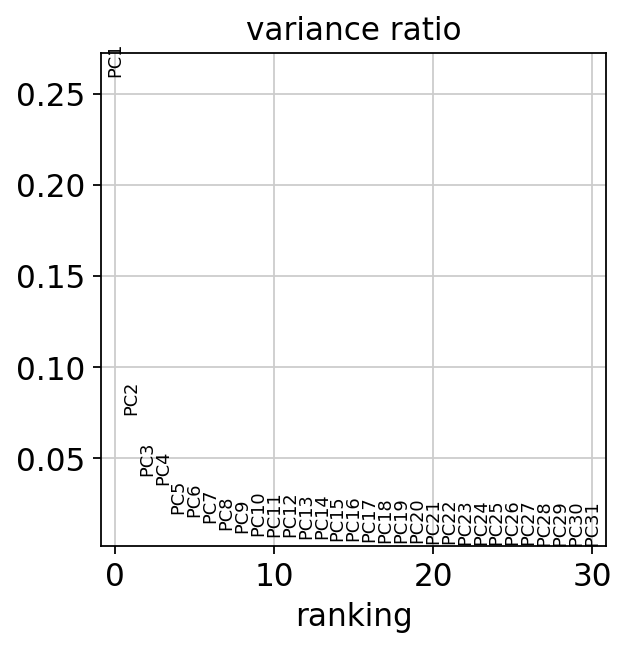

In [25]:
sc.set_figure_params(figsize=(4, 4))
sc.pl.pca_variance_ratio(adata, log=False)

In [26]:
adata

AnnData object with n_obs × n_vars = 59577 × 4000
    obs: 'Tissue', 'cell.labels', 'lanes', 'sample', 'study', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline', 'leiden_res0_25', 'S_score', 'G2M_score', 'phase', 'phase_combined', 'S/G2M_score_combined', 'Level 1', 'Level 2', 'Max-Rho', 'Combined Correlation DiffScore', 'cell_type_jardine', 'prediction.score.max_jardine', 'batch'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'highly_variable-1', 'gene_id-1', 'n_cells-1', 'feature_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca', 'X_orig_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'counts'
    obsp: 'distances', 'connectivities'

In [27]:
sc.pp.neighbors(adata, 
                n_neighbors=30, n_pcs=50, use_rep=None, knn=True, random_state=0, method='umap', metric='euclidean', 
                 key_added=None, copy=False)

In [28]:
sc.tl.umap(adata, 
               min_dist=0.5, spread=1.0, n_components=2, maxiter=None, 
               alpha=1.0, gamma=1.0, negative_sample_rate=5, init_pos='spectral', 
               random_state=0, a=None, b=None, copy=False, method='umap', neighbors_key=None)


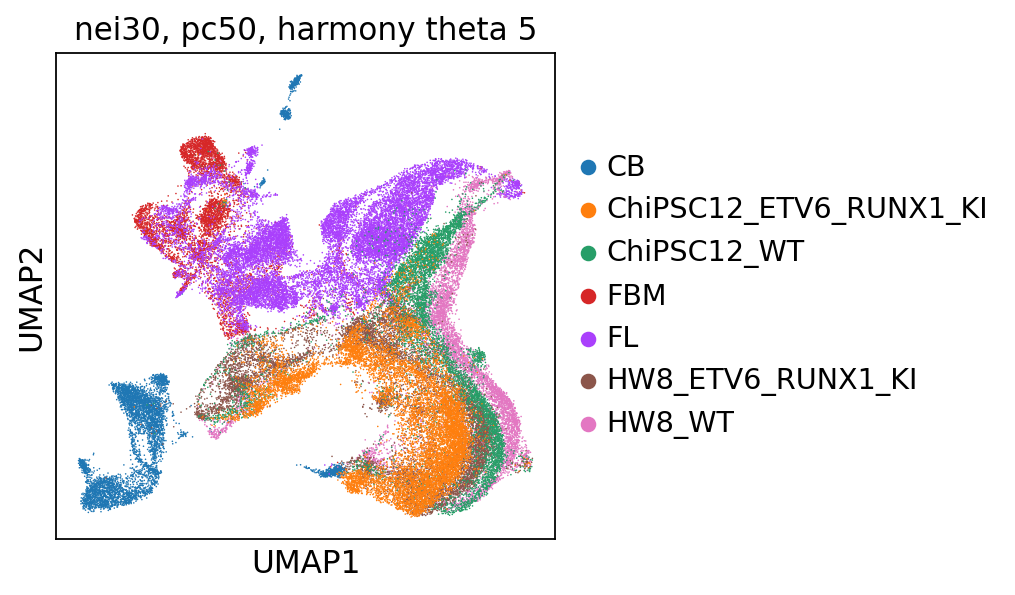

In [29]:
sc.pl.umap(
         adata, 
          color= "sample",
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=True,
    
     title = "nei30, pc50, harmony theta 5",
   #  save="UMAPs_p99_Reds.svg"
)

In [30]:
adata.write ("./data/ipsc_jardinecd34_harmony.h5ad")

In [31]:
adata

AnnData object with n_obs × n_vars = 59577 × 4000
    obs: 'Tissue', 'cell.labels', 'lanes', 'sample', 'study', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline', 'leiden_res0_25', 'S_score', 'G2M_score', 'phase', 'phase_combined', 'S/G2M_score_combined', 'Level 1', 'Level 2', 'Max-Rho', 'Combined Correlation DiffScore', 'cell_type_jardine', 'prediction.score.max_jardine', 'batch'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'highly_variable-1', 'gene_id-1', 'n_cells-1', 'feature_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors'
    obsm: 'X_umap', 'X_pca', 'X_orig_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'counts'
    obsp: 'distances', 'connectivities'

In [2]:
library(tidyverse)
library(data.table)
library(matrixStats)
library(ggplot2)
library(anndata)
#library(edgeR)
library(scales)
library(knitr)
library(RColorBrewer)
library("viridisLite")
library(dplyr)
library(tidyr)
library(SingleCellExperiment)
set.seed(2071)
theme_set(theme_classic())

#to be able to adjust figs
fig <- function(width, heigth){
options(repr.plot.width = width, repr.plot.height = heigth) }

In [4]:
adata = read_h5ad ("/research/groups/sysgen/PROJECTS/sysgen_team/andrea_work/2023_Fischer_iPSC/revision_final/data/ipsc_jardinecd34_harmony.h5ad")

In [5]:
raw_data <- as.matrix(adata$layers[["raw_counts"]])

In [8]:
umap_coords <- as.matrix(adata$obsm[["X_umap"]]) 
colnames(umap_coords) <- paste0("UMAP_", seq_len(ncol(umap_coords)))

sce <- SingleCellExperiment(
    assays = list(
        counts = t(raw_data) 
    ),
    colData = as.data.frame(adata$obs) 
)

reducedDims(sce) <- list(UMAP = umap_coords)

In [9]:
sce

class: SingleCellExperiment 
dim: 4000 59577 
metadata(0):
assays(1): counts
rownames(4000): AL645608.2 HES4 ... MT-ND6 MT-CYB
rowData names(0):
colnames(59577): AAACGAACACTGGATT-0-0 AAACGCTGTTATGTGC-0-0 ...
  TTTGTTGTCCGTATAG-4-1 TTTGTTGTCGTAGGAG-4-1
colData names(25): Tissue cell.labels ... prediction.score.max_jardine
  batch
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):

In [11]:
head(adata$obs$sample)

[1] FBM FBM FBM FBM FBM FBM
7 Levels: CB ChiPSC12_ETV6_RUNX1_KI ChiPSC12_WT FBM FL ... HW8_WT

In [50]:
colors_samples <- c(
  'HW8_WT' = "#006400",  # Dark Green
  'HW8_ETV6_RUNX1_KI' = "#C2E699",  # Light Lime-Green
  'ChiPSC12_WT' = "#1E3A8A",  # Navy Blue
  "ChiPSC12_ETV6_RUNX1_KI" = "#B3DDF2",  # Very Light Sky Blue
  "CB" = "#B5776C",  # SaddleBrown
  "FBM" = "pink",
  "FL" = "#D10326"   # Crimson Red
)


In [51]:
df <- bind_cols(
  as.data.frame(reducedDims(sce)$UMAP),
  as.data.frame(colData(sce)[, -3])
  ) %>%
  sample_frac(1)

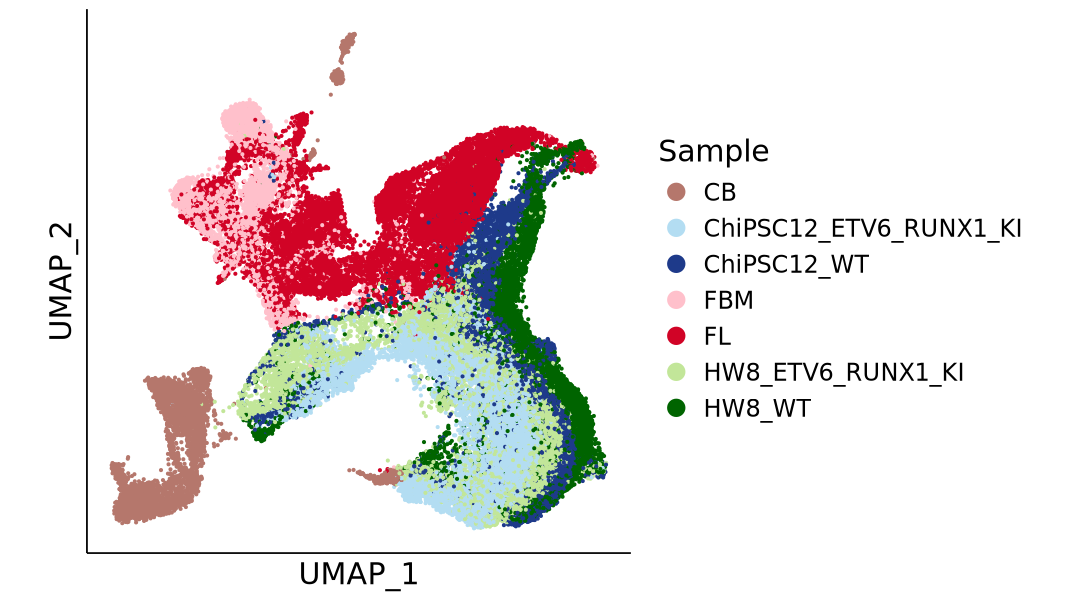

In [52]:
p2 <- ggplot(df, aes(x = UMAP_1, 
                     y = UMAP_2, 
                     col = sample)) +
  geom_point(size = 0.5, alpha = 1) +
  scale_color_manual(values = colors_samples, 
                     guide = guide_legend(keyheight = 1.5, 
                                          keywidth = 1.5,
                                         override.aes = list(size = 4.5))) + 
  labs(col = "Sample") +
  theme(
    text = element_text(size = 18),
    aspect.ratio = 1, 
    legend.position = "right", 
    axis.text.x = element_blank(), 
    axis.text.y = element_blank(), 
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank() 
  )

fig (9,5)
p2


In [53]:
ggsave("./figs/UMAP_tissues-07-Dec-24.pdf", 
       plot = p2, width = 9, height = 5)